In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file = 'global_data_4_0.5'
time_bins = np.arange(0,24,float(file.split('_')[-1]))
H_bins = np.arange(90,130,float(file.split('_')[-2]))

shape = len(time_bins) * len(H_bins)

file_path = f'../../Output/{file}.csv'

In [3]:
data_df = pd.read_csv(file_path,low_memory=False)
Ne_EXP = np.array(data_df['EXP Density']).reshape(-1,shape)
dNe_EXP =  np.array(data_df['EXP Density Error']).reshape(-1,shape)
Ne_WACCM = np.array(data_df['WACCM Density']).reshape(-1,shape)
mag_EXP = np.array(data_df['EXP Magnitude']).reshape(-1,shape)
mag_WACCM = np.array(data_df['WACCM Magnitude']).reshape(-1,shape)
height = np.array(data_df['Height']).reshape(-1,shape)
Date = np.array(data_df['Date']).reshape(-1,shape)[:,0]
Svalbard = np.array(data_df ['Svalbard']).reshape(-1,shape)[:,0] == 1
Tromso = np.array(data_df['Tromso']).reshape(-1,shape)[:,0] == 1
Geomagnetic_Event = np.array(data_df['Geomagnetic Event']).reshape(-1,shape)[:,0] == 1
Solar_Proton_Event = np.array(data_df['Solar Proton Event']).reshape(-1,shape)[:,0] == 1

masks = [Svalbard, Geomagnetic_Event, (~Geomagnetic_Event) * (~Solar_Proton_Event), Tromso, Solar_Proton_Event, (Geomagnetic_Event) + (Solar_Proton_Event)]
types = ['Svalbard', 'Geomagnetic Storms', 'Quiet', 'Tromso', 'Solar Proton', 'Active']

Mean magnitude error: 0.44 for Svalbard events
Mean magnitude error: 0.4 for Geomagnetic Storms events
Mean magnitude error: 0.43 for Quiet events
Mean magnitude error: 0.41 for Tromso events
Mean magnitude error: 0.5 for Solar Proton events
Mean magnitude error: 0.44 for Active events


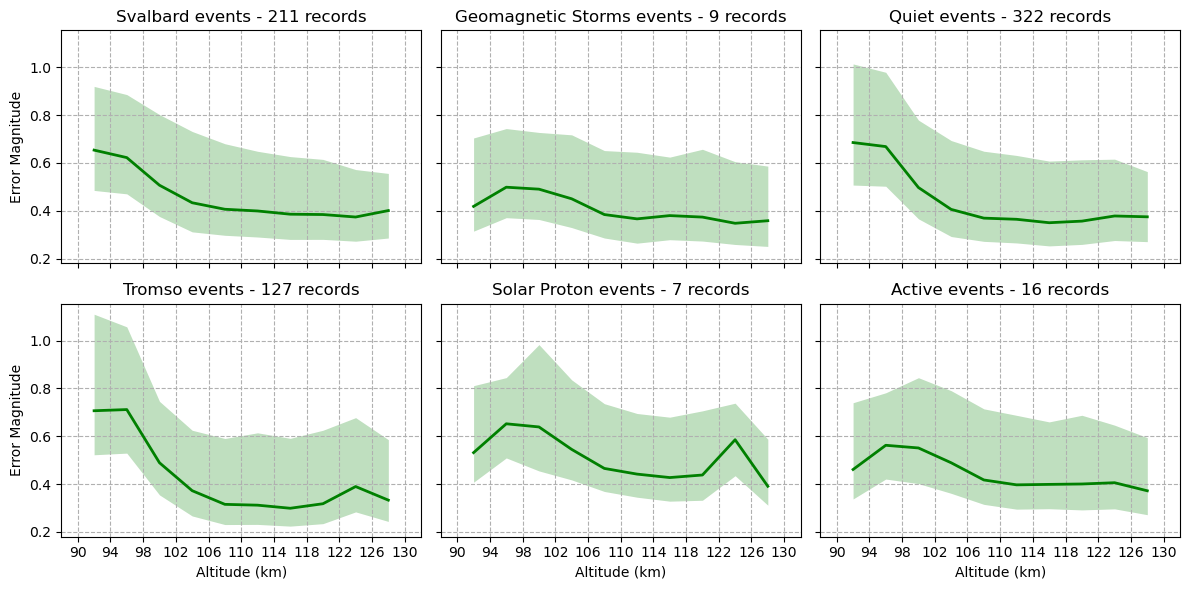

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)


for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_height = height[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2
    dNe_EXP_2 = dNe_fac

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    height_flat = temp_height[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for H_bin in H_bins:
        h_mask = height_flat == H_bin
        mean_value = np.mean(Ne_diff_flat[h_mask])
        mean_list.append(mean_value)
        less_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]<mean_value]))
        more_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]>mean_value]))

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(H_bins)

    axs[i // 3][i % 3].fill_between(x + (H_bins[1] - H_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (H_bins[1] - H_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')
    print(f'Mean magnitude error: {int(100*np.mean(Ne_diff_flat))/100} for {type} events')

axs[1][0].set_xlabel('Altitude (km)')
axs[1][1].set_xlabel('Altitude (km)')
axs[1][2].set_xlabel('Altitude (km)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.xticks(np.concatenate((H_bins,[130])))
plt.xlim((88, 132))
plt.savefig(f'../../Output/Figures/error-events.png')
plt.show()